In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
json_para = json.load(open(r"E:\graphsum\data\WikiSum_data_tfidf_paddle\test\WIKI.test.0.json", encoding="utf-8"))
json_sent = json.load(open(r"E:\graphsum\data\WikiSum_data_tfidf_paddle\test\WIKI.test.sentence.0.json", encoding="utf-8"))

In [3]:
max_num_sent = np.max([len(ex["sim_graph"]) for ex in json_sent])

In [5]:
para_weights = np.empty(shape=[len(json_para),40,40])
para_weights[:] = np.nan
sent_weights = np.empty(shape=[len(json_para),max_num_sent,max_num_sent])
sent_weights[:] = np.nan

para_weight_list = []
sent_weight_list = []

para_mean_array = np.zeros(shape=[len(json_para)])
sent_mean_array = np.zeros(shape=[len(json_para)])

para_sum_array = np.zeros(shape=[len(json_para)])
sent_sum_array = np.zeros(shape=[len(json_para)])

para_weight_list_mapping = []
sent_weight_list_mapping = []

sentence_length = []
paragraph_length = []



for i in range(len(json_para)):
    para_weight_list.extend(np.array(json_para[i]["sim_graph"]).reshape(-1,))
    sent_weight_list.extend(np.array(json_sent[i]["sim_graph"]).reshape(-1,))
    
    
    sentence_length.extend([len(sent) for sent in json_sent[i]["src"]])
    paragraph_length.extend([len(para) for para in json_para[i]["src"]])
    
    
    para_weights[i,:len(json_para[i]["sim_graph"]),:len(json_para[i]["sim_graph"])] = json_para[i]["sim_graph"]
    sent_weights[i,:len(json_sent[i]["sim_graph"]),:len(json_sent[i]["sim_graph"])] = json_sent[i]["sim_graph"]
        
    
    length_array = []
    for ex in json_para[i]["src"]:
        length = 0
        tmp = np.unique(ex, return_counts=True)[1][np.unique(ex, return_counts=True)[0] == 11]

        if len(tmp) > 0:
            length += tmp[0]

        if ex[-1] != 11:
            length += 1


        length_array.append(length)
    
    
    length_array = np.cumsum([0] + length_array)
    for j in range(len(length_array)-1):
        
        tmp = sent_weights[i,length_array[j]:length_array[j+1],:]
        mean_sent = np.nanmean(tmp,axis=1)
        sent_weight_list_mapping.append(mean_sent)
        
        
        para_value = np.nanmean(para_weights[i,j,:])
        para_weight_list_mapping.append(np.repeat(para_value,len(mean_sent)))
        





C:\Users\arnem\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


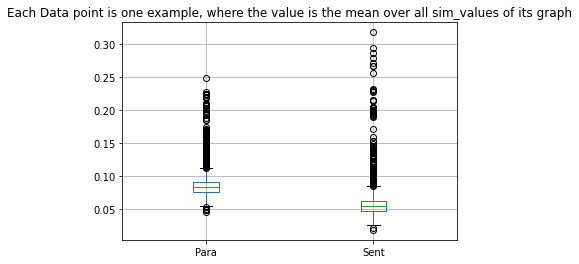

<Figure size 432x288 with 0 Axes>

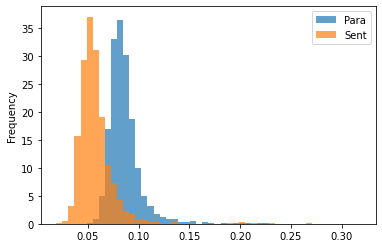

In [6]:
df = pd.DataFrame(np.stack([np.nanmean(para_weights,axis=(1,2)), np.nanmean(sent_weights,axis=(1,2))],axis=1), columns=['Para', 'Sent'] )

plt.figure()
plt.title("Each Data point is one example, where the value is the mean over all sim_values of its graph")
df.boxplot()
display()
plt.figure();
df.plot.hist(bins=50, alpha=0.7, density=True)
display()


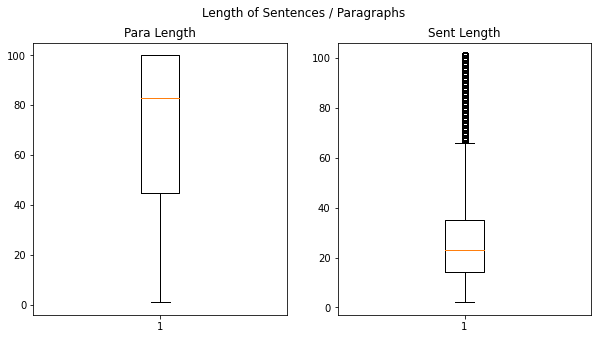

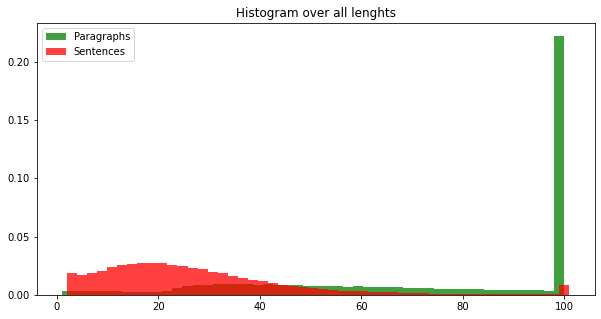

In [14]:
fig1, ax1 = plt.subplots(1,2, figsize=(10,5))

plt.suptitle("Length of Sentences / Paragraphs")
ax1[0].set_title('Para Length')
ax1[0].boxplot(paragraph_length)

ax1[1].set_title('Sent Length')
ax1[1].boxplot(sentence_length)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(paragraph_length, 50, density=True, facecolor='g', alpha=0.75, label="Paragraphs")

n, bins, patches = plt.hist(sentence_length, 50, density=True, facecolor='r', alpha=0.75, label="Sentences")

plt.title("Histogram over all lenghts")
plt.legend()
display()

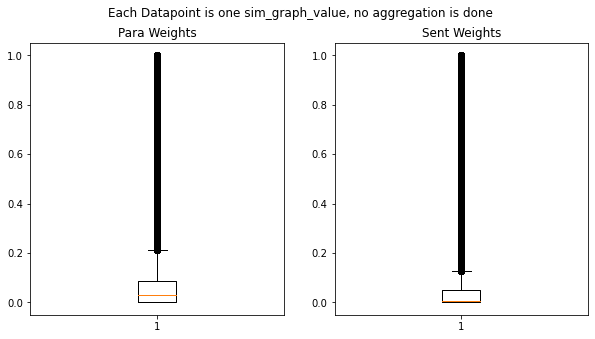

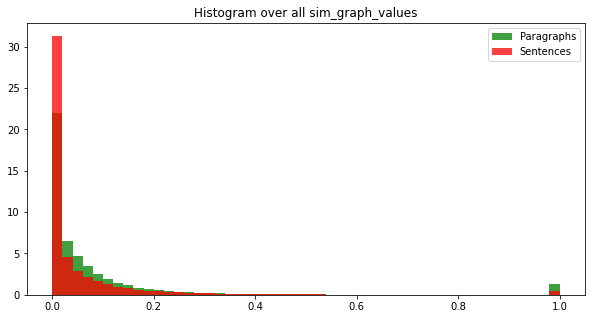

In [8]:
fig1, ax1 = plt.subplots(1,2, figsize=(10,5))

plt.suptitle("Each Datapoint is one sim_graph_value, no aggregation is done")
ax1[0].set_title('Para Weights')
ax1[0].boxplot(para_weight_list)

ax1[1].set_title('Sent Weights')
ax1[1].boxplot(sent_weight_list)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(para_weight_list, 50, density=True, facecolor='g', alpha=0.75, label="Paragraphs")

n, bins, patches = plt.hist(sent_weight_list, 50, density=True, facecolor='r', alpha=0.75, label="Sentences")

plt.title("Histogram over all sim_graph_values")
plt.legend()
display()

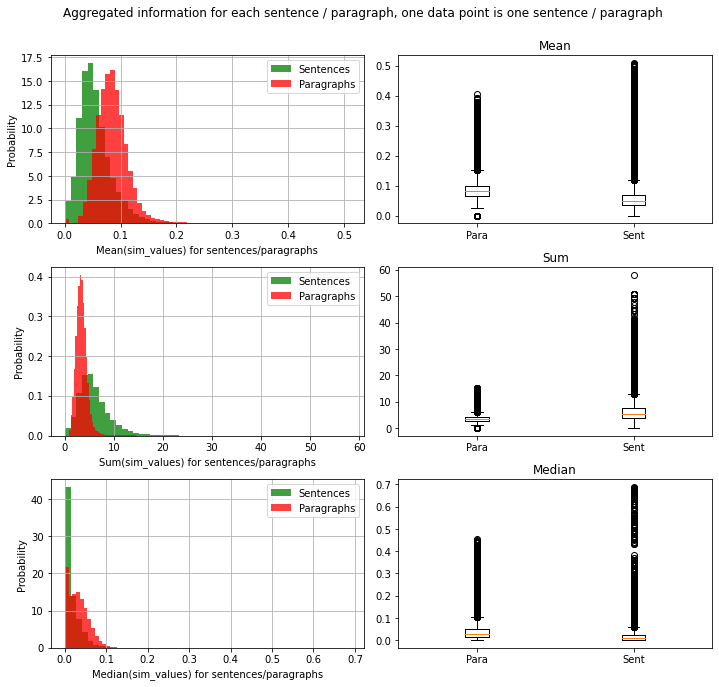

In [9]:
functions_to_apply = [{"name": "Mean", "fun": np.nanmean}, {"name": "Sum", "fun": np.nansum}, {"name": "Median", "fun": np.nanmedian}]

fig, axs = plt.subplots(len(functions_to_apply),2,figsize=(10,10))


para_mask = np.all(np.isnan(para_weights), axis=2)
tmp_para_weights = para_weights[~para_mask]

sent_mask = np.all(np.isnan(sent_weights), axis=2)
tmp_sent_weights = sent_weights[~sent_mask]

for i,fun in enumerate(functions_to_apply):



    n, bins, patches = axs[i,0].hist(fun["fun"](tmp_sent_weights,axis=1).reshape(-1,), 50, density=True, facecolor='g', alpha=0.75, label="Sentences")

    axs[i,1].boxplot([fun["fun"](tmp_para_weights,axis=1).reshape(-1,), fun["fun"](tmp_sent_weights,axis=1).reshape(-1,)])
    
    axs[i,1].set_xticklabels(["Para", "Sent"])

  
    
    axs[i,0].set_xlabel('%s(sim_values) for sentences/paragraphs' % (fun["name"]))
    axs[i,0].set_ylabel('Probability')
    axs[i,1].set_title(fun["name"])
    #axs[i].set_text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)

    axs[i,0].grid(True)
    n, bins, patches = axs[i,0].hist(fun["fun"](tmp_para_weights,axis=1).reshape(-1,), 50, density=True, facecolor='r', alpha=0.75, label="Paragraphs")
    axs[i,0].legend()

plt.suptitle("Aggregated information for each sentence / paragraph, one data point is one sentence / paragraph")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

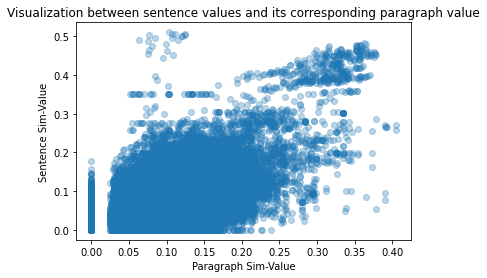

In [10]:
plt.figure()
plt.title("Visualization between sentence values and its corresponding paragraph value")
plt.scatter([value for para in para_weight_list_mapping for value in para], [value for sent in sent_weight_list_mapping for value in sent], alpha=0.3)
plt.xlabel("Paragraph Sim-Value")
plt.ylabel("Sentence Sim-Value")
display()

C:\Users\arnem\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\arnem\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


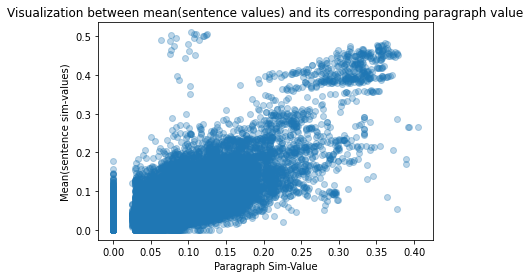

In [11]:
plt.figure()
plt.title("Visualization between mean(sentence values) and its corresponding paragraph value")
plt.scatter([np.mean(para) for para in para_weight_list_mapping], [np.mean(sent) for sent in sent_weight_list_mapping], alpha=0.3)
plt.xlabel("Paragraph Sim-Value")
plt.ylabel("Mean(sentence sim-values)")
display()

In [12]:
pd.DataFrame(np.stack([[np.mean(para) for para in para_weight_list_mapping], [np.mean(sent) for sent in sent_weight_list_mapping]],axis=1) , columns=["para","sent"]).corr()

,para,sent
para,1.000000,0.639089
sent,0.639089,1.000000


In [13]:
pd.DataFrame(np.stack([[value for para in para_weight_list_mapping for value in para], [value for sent in sent_weight_list_mapping for value in sent]],axis=1) , columns=["para","sent"]).corr()

,para,sent
para,1.000000,0.454039
sent,0.454039,1.000000
